# import necessary libraries

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
import re
import string

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression

# read data 

In [2]:
traindata = pd.read_csv("train.csv")
testdata = pd.read_csv("test.csv")
submissiondata = pd.read_csv("sample_submission.csv") 

# Exploratory Data Analysis

In [3]:
traindata.head(1)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1


In [4]:
testdata.head(1)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash


In [5]:
disaster_tweets = traindata[traindata['target']==1]
disaster_tweets.head(1)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1


In [6]:
notdisaster_tweets = traindata[traindata['target']==0]
notdisaster_tweets.head(1)

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0


In [7]:
traindata.shape

(7613, 5)

the Number of not real disasters:  4342
the Number of real disasters :  3271


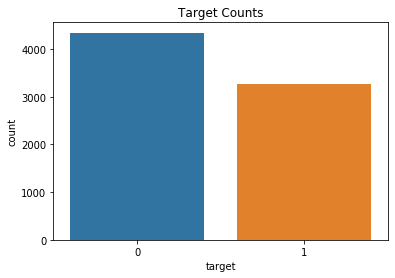

In [8]:
y = traindata.target
F, T = y.value_counts()

fig1 = sns.countplot(y,label = 'count')
plt.title('Target Counts')
plot = fig1.get_figure()
plot.savefig('Count Plot.png')

print('the Number of not real disasters: ',F)
print('the Number of real disasters : ',T)

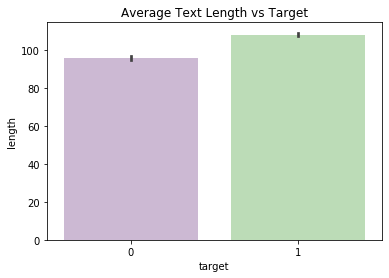

In [9]:
traindata['length'] = traindata['text'].apply(len)
fig1 = sns.barplot('target','length',data = traindata,palette='PRGn')
plt.title('Average Text Length vs Target')
plot = fig1.get_figure()
plot.savefig('Barplot.png')

In [10]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
length      7613 non-null int64
dtypes: int64(3), object(3)
memory usage: 357.0+ KB


In [11]:
#from this, we can see that there are many missing value in keyword column and location column.

In [12]:
traindata.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88


In [13]:
testdata.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [14]:
testdata.shape

(3263, 4)

In [15]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [16]:
submissiondata.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [17]:
traindata1 = traindata.drop(['keyword', 'location', 'id'], axis=1)
traindata1.head()

,text,target,length
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69
1,Forest fire near La Ronge Sask. Canada,1,38
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133
3,"13,000 people receive #wildfires evacuation orders in California",1,65
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88


In [18]:
testdata['length'] = testdata['text'].apply(len)
testdata1 = testdata.drop(['keyword', 'location', 'id'], axis=1)
testdata1.head()

,text,length
0,Just happened a terrible car crash,34
1,"Heard about #earthquake is different cities, stay safe everyone.",64
2,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",96
3,Apocalypse lighting. #Spokane #wildfires,40
4,Typhoon Soudelor kills 28 in China and Taiwan,45


# Feature Engineering

In [19]:
def text_processing(tweet):
    
    #Generating the list of words in the tweet (hastags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
    
    return normalization(no_punc_tweet)
    

In [20]:
traindata1['cleantext'] = traindata1['text'].apply(text_processing)
#testdata['tweet_list'] = testdata['text'].apply(text_processing)

In [21]:
traindata1['cleantext'][:5]

0    [Deeds, Reason, earthquake, May, ALLAH, Forgive, us]                               
1    [Forest, fire, near, La, Ronge, Sask, Canada]                                      
2    [residents, ask, place, notify, officer, evacuation, shelter, place, order, expect]
3    [people, receive, wildfires, evacuation, order, California]                        
4    [get, send, photo, Ruby, Alaska, smoke, wildfires, pour, school]                   
Name: cleantext, dtype: object

In [22]:
traindata.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88


# Model Selection and Machine Learning

In [23]:
y = traindata['target']
X = traindata.drop(['keyword', 'location', 'id','target'], axis=1)
test = testdata.drop(['keyword', 'location', 'id'], axis=1)

In [24]:
X.shape

(7613, 2)

In [25]:
y.shape

(7613,)

In [26]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [27]:
#Machine Learning Pipeline
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
pipeline.fit(x_train,y_train)

ValueError: Found input variables with inconsistent numbers of samples: [2, 6090]

In [ ]:
predictions = pipeline.predict(msg_test)

print(classification_report(predictions,label_test))
print ('\n')
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))